In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
state = 7
np.random.seed(state)
import random
random.seed(state)

## Exploring Dataset 

In [3]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


In [4]:
def longest(x):
    l = 0
    for i in x:
        if len(i) > l:
            l = len(i)
    return l

X = list(df['Review'])
length = []
for i in X:
    length.append(len(i))

In [5]:
longest(df['Review'])

13501

In [6]:
sum(length)/len(length)

724.896832755844

## Stopwords 

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopword = stopwords.words('english')
execption = ['they','them','their','theirs','what','which','who','why', 'how','when','where','how', 'few', 'no','nor','not','can',
             'will',"don't",'should', "should've","aren't",'couldn','only','too','very','don',"aren't",'couldn','but','did',"couldn't",
             "didn't",'doesn',"doesn't", 'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'mightn',"mightn't",
             'mustn',"mustn't",'needn', "needn't","shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't","won't",'wouldn',
             "wouldn't",'ain','aren', 'didn', 'don']
stop = [x for x in stopword if x not in execption]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Madridista\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Madridista\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Madridista\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data preprocessing 

In [9]:
import re
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [19]:
def preprocess(X):
    corpus = []
    for i in range(len(X)):
        review = re.sub('[^a-zA-Z]',' ', X[i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(x) for x in review if x not in stop]
        review = ' '.join(review)
        corpus.append(review)
    return corpus

In [20]:
corpus = preprocess(list(df['Review']))

## TFIDF 

In [21]:
from sklearn.model_selection import train_test_split
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(corpus, y, stratify = y, test_size = 0.2, random_state = state)

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [24]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range = (1,2), max_features = 8000)),
    ('model', LogisticRegression(class_weight = 'balanced', multi_class = 'ovr'))
])

In [25]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=8000, ngram_range=(1, 2))),
                ('model',
                 LogisticRegression(class_weight='balanced',
                                    multi_class='ovr'))])

## Evaluation

In [26]:
pipe.score(X_test, y_test)

0.6250304952427421

In [27]:
y_pred_proba = pipe.predict_proba(X_test)
y_pred = pipe.predict(X_test)

In [28]:
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
roc_auc_score(y_test, y_pred_proba, multi_class = 'ovr')

0.8705488597931342

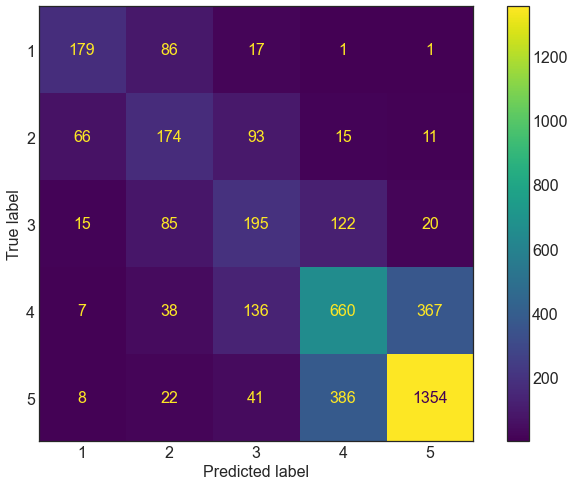

In [29]:
plt.style.use('seaborn-white')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize = (12, 8))
plot_confusion_matrix(pipe, X_test, y_test, ax = ax)

## Saving pipeline and prediction for new reviews 

In [30]:
import joblib
joblib.dump(pipe, 'tfidf_model')

['tfidf_model']

In [ ]:
model = joblib.load('tfidf_model')

In [ ]:
res = model.predict_proba([input()])

In [ ]:
top3 = dict()
for i in range(len(res[0])):
    top3[i + 1] = np.round(res[0][i] * 100, 2)

In [ ]:
c = Counter(top3)
for k,v in c.most_common(5):
    print(k,':',v)